# Supervised Community Detection with Line Graph Neural Network
An implementation of [_Supervised Community Detection with Line Graph Neural Network. Z Chen._](https://arxiv.org/abs/1705.08415) with pyTorch

In [0]:
!git clone https://github.com/mehdibalouchi/GNN

Cloning into 'GNN'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 42 (delta 17), reused 33 (delta 11), pack-reused 0
Unpacking objects: 100% (42/42), done.


### Helper functions
We first implement some helper functions for later usage. Each function has a `docstring` that provides information about its usage and arguments.
<br><br>
#### Data Loader
Function `load_data_lgnn` loads Cora Binary dataset and prepares necessary objects for training and evaluating our model. The Cora Binary dataset is provided by DGL(Deep Graph Library). `load_data_lgnn` returns a list of graphs; each graph is a dictionary containing following keys with described values:<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__edges__: A list of graph edge tuples. _e.g: [(2, 3), (35, 43), ...]_<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__labels__: Labels of graph nodes<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__adj_g_sp__: Graph adjecency matrix in form of `scipy.coo_matrix`<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__adj_g__: Graph adjacency matrix in form of `pytorch.Tensor`<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__nx__: Graph in form of `networkx.Graph`<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__deg_g__: Degree vector of graph<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__adj_lg__: Line graph associated with the graph in form of `pytorch.Tensor`<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__deg_lg__: Degree vector of line graph assiciated with the graph<br>
<br>
In order to build line graph associated to each graph, we use `line_graph(edges)`. It returns two `numpy.ndarray` _rows_ and _columns_ that indicate row and column of all non-zero elements of line graph adjacency matrix. This is because we are going to create a sparse matrix with them and we only need the position of non-zero elements, in case of weighted graphs we should add a _values_ list as well.
<br><br>
#### Line Graph
Given graph $\mathcal{G}=(\mathcal{V},\mathcal{E})$ wehere $\mathcal{V} = \{v_1,v_2,...,v_N \}$ is the set of vertices, $\mathcal{E}$ is the set of edges with size $|\mathcal{E}|=E$, the line graph associated with $\mathcal{G}$, is defined by the **_non-backtracing operator_** as below:<br><br>
$B_{(i \to j),(i^{\prime} \to j^{\prime})} = 
\begin{cases} 
1 \qquad \text{if $j=i^{\prime}$ and $j^{\prime}\neq i,$} \\
0 \qquad \text{otherwise}
\end{cases}$
<br><br>
Note that even if $\mathcal{G}$ is undirected, it's associated line graph, $L(\mathcal{G}$) is directed, so $L(\mathcal{G}$) has $2|E|$ nodes.


In [0]:
import numpy as np
import scipy.sparse as sp
import torch
import networkx as nx
import matplotlib.pyplot as plt


def encode_onehot(labels):
    """ 
    Encode a vector to onehot
    
    :param labels: vector of labels to be encoded to onehot
    :returns: a vector of onehot encoding of each number in `labels`
    """

    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def line_graph(edges):
  """
  Calculate line graph of a given graph, input graph is in form of edge tuples

  :param edges: list of edge tuples of graph
  :returns: two numpy arrays denoting row and columns of non-zero elements in line-graph adjacency matrix
  """

  edge_map = dict()
  for idx, edge in enumerate(edges):
    src, dst = edge

    if not src in edge_map:
      edge_map[src] = dict()
    
    edge_map[src][dst] = idx

  row = []
  col = []

  for idx, edge in enumerate(edges):
    src, dst = edge
    for dst_2 in edge_map[dst]:
      if dst_2 != src:
        row.append(idx)
        col.append(edge_map[dst][dst_2])
  
  return np.array(row), np.array(col)


def load_data_lgnn(path='./GNN/data/cora_binary/'):
  """
    Load Cora Binary dataset.
    The function expects three files to be present in `path` dir: graphs.txt, labels.txt and pmpds.pkl

    :param path: path to a directory containing graphs, labels and pmpds files

    :returns: A list of dictionaries, each dictionary is a graph that consists of following keys:
        edges: List of graph edge tuples,
        labels: Labels of graph nodes,
        pmpd: pmpd matrix of graph,
        adj_g_sp: Graph adjacency matrix in form of scipy `coo_matrix`,
        adj_g: Graph adjacency matrix in form of Tensor,
        nx: Networkx.Graph instance of graph,
        deg_g: Degree vector of graph,
        adj_lg: Line Graph adjecency matrix in form of Tensor,
        deg_lg: Line Graph degree vector
  """

  import numpy as np
  import scipy.sparse as sp
  import torch
  import pickle

  graphs_txt = list(map(lambda x: x.replace('\n', ''),
                  open(path + 'graphs.txt').readlines()))
  break_idx = [idx for idx, edge in enumerate(graphs_txt) if edge == 'graph']
  bound = [[break_idx[i], break_idx[i+1]] for i in range(len(break_idx)-1)]
  bound.append([break_idx[-1], len(graphs_txt)])

  edges = []
  for bnd in bound:
    graph = np.array(list(map(lambda x: list([int(i) for i in x.split()]), graphs_txt[bnd[0]+1 : bnd[1]])))
    edges.append(graph)


  labels_txt = list(map(lambda x: x.replace('\n', ''),
                        open(path + 'labels.txt').readlines()))
  break_idx = [idx for idx, label in enumerate(labels_txt) if label == 'graph']
  bound = [[break_idx[i], break_idx[i+1]] for i in range(len(break_idx)-1)]
  bound.append([break_idx[-1], len(labels_txt)])

  labels = []
  for bnd in bound:
    graph = np.array(list(map(lambda x: int(x), labels_txt[bnd[0]+1 : bnd[1]])))
    labels.append(graph)

  pmpds = pickle.load(open(path + 'pmpds.pkl', 'rb'))

  graphs = []
  for idx, graph in enumerate(edges):
    _graph = dict()
    _graph['edges'] = torch.FloatTensor(graph)
    _graph['labels'] = torch.LongTensor(labels[idx])
    _graph['pmpd'] = sparse_mx_to_torch_sparse_tensor(pmpds[idx])
    
    adj = sp.coo_matrix((np.ones(graph.shape[0]), (graph[:,0], graph[:,1])),
                                      shape=(labels[idx].shape[0], labels[idx].shape[0]),
                                      dtype=np.float32)
    # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    # adj = normalize(adj + sp.eye(adj.shape[0]))
    _graph['adj_g_sp'] = adj # Remove this
    _graph['adj_g'] = sparse_mx_to_torch_sparse_tensor(adj)

    graph_nx = nx.from_scipy_sparse_matrix(adj)
    _graph['nx'] = graph_nx
    _graph['deg_g'] = np.array([deg[1] for deg in graph_nx.degree]).reshape(-1, 1)
    _graph['deg_g'] = torch.FloatTensor(_graph['deg_g'])

    lg_row, lg_col = line_graph(graph)
    adj_lg = sp.coo_matrix((np.ones(lg_row.shape[0]), (lg_row, lg_col)),
                           shape=(graph.shape[0], graph.shape[0]),
                           dtype=np.float32)
    # adj_lg = adj_lg + adj_lg.T.multiply(adj_lg.T > adj_lg) - adj_lg.multiply(adj_lg.T > adj_lg)
    # adj_lg = normalize(adj_lg + sp.eye(adj_lg.shape[0]))
    _graph['adj_lg'] = sparse_mx_to_torch_sparse_tensor(adj_lg)

    line_graph_nx = nx.from_scipy_sparse_matrix(adj_lg)
    _graph['deg_lg'] = np.array([deg[1] for deg in line_graph_nx.degree]).reshape(-1, 1)
    _graph['deg_lg'] = torch.FloatTensor(_graph['deg_lg'])

    graphs.append(_graph)
  
  return graphs
    

def normalize(mx):
    """
    Row-normalize sparse matrix

    :param mx: saprse matrix to be row-normalized
    :returns: row-normalized sparse matrix
    """

    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    """
    Calculate accuracy given true labels and model output (rate of correct predictions)

    :param output: Model's output
    :param labels: True labels
    :returns: A scalar denoting correct prediction ratio
    """

    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Convert a scipy sparse matrix to a torch sparse tensor.

    :param sparse_mx: scipy sparse matrix to be converted to torch sparse tensor
    :returns: A torch spare tensor
    """

    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def visualize(labels, g, cmap=plt.get_cmap('coolwarm')):
    """
    Visualize a networkx.Graph object with given labels

    :param labels: Label for graph nodes
    :param g: networkx.Graph instance of graph
    :param cmap: color map
    """

    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=50, cmap=cmap,
                     node_color=labels, edge_color='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False)


## Power Layer
LGNN chains together a series of line graph neural network layers. The graph representation x and its line graph companion y evolve with the dataflow as follows.
At the $k$-th layer, the $i$-th neuron of the $l$-th channel updates its embedding $x^{(k+1)}_{i,l}$ with:<br>
$x^{(k+1)}_{i,l} = \rho[x_i^{(k)}\theta_{1,l}^{(k)} + $<br>$\qquad\qquad\quad 
(Dx^{(k)})_i\theta_{2,l}^{(k)} + $<br>$\qquad\qquad\quad
\sum_\limits{j=0}^{J-1}(A^{2^j}x^k)_i\theta_{3+j,l}^{(k)} + $<br>$\qquad\qquad\quad
[\{Pm,Pd\}y^{(k)}]_i\theta_{3+J,l}^{(k)}] + $<br>$\qquad\qquad\quad
\text{skip-connection} \qquad i \in V,l=1,2,3,...,{b_{(k+1)}\over2}$ 
<br><br>
Then, the line-graph representation $y^{(k+1)}_{i,l}$ with:<br>

$y^{(k+1)}_{i^{\prime},l^{\prime}} = \rho[y_{i^{\prime}}^{(k)}\gamma_{1,l^{\prime}}^{(k)} + $<br>$\qquad\qquad\quad 
(D_{L(G)}y^{(k)})_{i^{\prime}}\gamma_{2,l^{\prime}}^{(k)} + $<br>$\qquad\qquad\quad
\sum_\limits{j=0}^{J-1}(A^{2^j}_{L(G)}y^k)_{i^{\prime}}\gamma_{3+j,l^{\prime}}^{(k)} + $<br>$\qquad\qquad\quad
[\{Pm,Pd\}^Tx^{(k+1)}]_{i^{\prime}}\gamma_{3+J,l^{\prime}}^{(k)}] + $<br>$\qquad\qquad\quad
\text{skip-connection} \qquad i^{\prime} \in V_l,l^{\prime}=1,2,3,...,{b^{\prime}_{(k+1)}\over2}$ 
<br><br>
Where $\text{skip-connection}$ refers to performing the same operation without the non-linearity $\rho$, and with linear projection $\theta\{{b_{k+1}\over2}+1,...,b_{k+1}−1,b_{k+1}\}$ and $\gamma\{{b^{\prime}_{k+1}\over2}+1,...,b^{\prime}_{k+1}−1,b^{\prime}_{k+1}\}$.

<br>
$Pm,Pd \in \{0,1\}^{|V|×2|E|}$,defined as $Pm_{i,(i→j)}= 1$, $Pm_{j,(i→j)}= 1$, $Pd_{i,(i→j)}= 1$, $Pd_{j,(i→j)}=−1$ and $0$ otherwise.

In [0]:
import math

import torch
import torch.nn

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.functional import relu

class LGNNLayer(Module):

  def __init__(self, in_features, out_features, radius):
    super(LGNNLayer, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.radius = radius

    self.feature_params_g = nn.Linear(in_features, out_features)
    self.degree_params_g = nn.Linear(in_features, out_features)
    self.power_params_g = nn.ModuleList([nn.Linear(in_features, out_features) for p in range(radius)])
    self.fusion_params_g = nn.Linear(in_features, out_features)
    self.bn_g = nn.BatchNorm1d(out_features)
    
    self.feature_params_lg = nn.Linear(in_features, out_features)
    self.degree_params_lg = nn.Linear(in_features, out_features)
    self.power_params_lg = nn.ModuleList([nn.Linear(in_features, out_features) for p in range(radius)])
    # self.fusion_params_lg = nn.Linear(in_features, out_features)
    self.fusion_params_lg = nn.Linear(out_features, in_features)
    self.bn_lg = nn.BatchNorm1d(out_features)
  
  def forward(self, adj_g, adj_lg, x, y, deg_g, deg_lg, pmpd):

    # GRAPH
    # Computing graph projections
    feature_g = self.feature_params_g(x)
    degree_g = self.degree_params_g(deg_g * x)
    
    power_adj_g = [torch.mm(adj_g ** (2 ** j), x) for j in range(self.radius)]
    power_g = sum([linear(x) for linear, x in zip(self.power_params_g, power_adj_g)])
    fusion_g = self.fusion_params_g(torch.mm(pmpd, y))

    next_x = feature_g + degree_g + power_g + fusion_g

    # skip connection
    n = self.out_features // 2
    next_x = torch.cat([next_x[:, :n], relu(next_x[:, n:])], 1)

    # batch normalization
    next_x = self.bn_g(next_x)


    # LINE GRAPH
    # Computing line-graph projections
    feature_lg = self.feature_params_lg(y)
    degree_lg = self.degree_params_lg(deg_lg * y)
    
    power_adj_lg = [torch.mm(adj_lg ** (2 ** j), y) for j in range(self.radius)]
    power_lg = sum([linear(x) for linear, x in zip(self.power_params_lg, power_adj_lg)])
    fusion_lg = self.fusion_params_lg(torch.mm(torch.transpose(pmpd, 0, 1), next_x))

    next_y = feature_lg + degree_lg + power_lg + fusion_lg

    # skip connection
    next_y = torch.cat([next_y[:, :n], relu(next_y[:, n:])], 1)

    # batch normalization
    next_y = self.bn_lg(next_y)

    return next_x, next_y
  
  def __repr__(self):
    return self.__class__.__name__ + ' (' \
      + str(self.in_features) + ' -> ' \
      + str(self.out_features) + ')'

## models.py

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class LGNN(nn.Module):
  def __init__(self, n_features, n_class, n_layers, n_hiddens, radius):
    super(LGNN, self).__init__()

    shape = [n_features] + n_hiddens
    self.layers = []
    for idx in range(n_layers - 1):
      self.layers.append(LGNNLayer(shape[idx], shape[idx+1], radius))
    
    self.layers = nn.ModuleList(self.layers)

    self.dense = nn.Linear(n_hiddens[-1], n_class)
  
  def forward(self, adj_g, adj_lg, x, y, deg_g, deg_lg, pmpd):
    for layer in self.layers:
      x, y = layer(adj_g, adj_lg, x, y, deg_g, deg_lg, pmpd)
    
    return self.dense(x)


## train.py

In [0]:
import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt

from collections import namedtuple

ARGS = namedtuple('ARGS', ['cuda', 'fastmode', 'seed', 'epochs', 'lr',
                           'weight_decay', 'hidden', 'radius'])

args = ARGS(cuda=True, fastmode=False, seed=42, epochs=20, lr=0.01,
            weight_decay=5e-4, hidden=16, radius=2)

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
print('Loading Data ...')
graphs = load_data_lgnn()
train_graphs = graphs[:-1]
test_graphs = graphs[-1:]

# Model and optimizer
model = LGNN(n_features=1, n_hiddens=[16] * 30, n_class=2, radius=args.radius, n_layers=30)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    for graph in graphs:
      graph['adj_g'] = graph['adj_g'].cuda()
      graph['adj_lg'] = graph['adj_lg'].cuda()
      graph['deg_g'] = graph['deg_g'].cuda()
      graph['deg_lg'] = graph['deg_lg'].cuda()
      graph['labels'] = graph['labels'].cuda()
      graph['pmpd'] = graph['pmpd'].cuda()

losses = []
accs = []
for i in range(args.epochs):
    t = time.time()
    all_loss = []
    all_acc = []
    for graph in train_graphs:

        # Forward
        z = model(graph['adj_g'],
                  graph['adj_lg'],
                  graph['deg_g'],
                  graph['deg_lg'],
                  graph['deg_g'],
                  graph['deg_lg'],
                  graph['pmpd'])

        # Calculate loss:
        # Since there are only two communities, there are only two permutations
        #  of the community labels.
        loss_perm1 = F.cross_entropy(z, graph['labels'])
        loss_perm2 = F.cross_entropy(z, 1 - graph['labels'])
        loss = torch.min(loss_perm1, loss_perm2)

        # Calculate accuracy:
        _, pred = torch.max(z, 1)
        acc_perm1 = (pred == graph['labels']).float().mean()
        acc_perm2 = (pred == 1 - graph['labels']).float().mean()
        acc = torch.max(acc_perm1, acc_perm2)
        all_loss.append(loss.item())
        all_acc.append(acc.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    niters = len(all_loss)
    print("Epoch %04d | loss %.4f | accuracy %.4f | time %.4f" % (i,
        sum(all_loss) / niters, sum(all_acc) / niters, time.time() - t))
    losses.append(sum(all_loss) / niters)
    accs.append(sum(all_acc) / niters)

graph = test_graphs[0]
z = model(graph['adj_g'],
                  graph['adj_lg'],
                  graph['deg_g'],
                  graph['deg_lg'],
                  graph['deg_g'],
                  graph['deg_lg'],
                  graph['pmpd'])

_, pred = torch.max(z, 1)

acc_perm1 = (pred == graph['labels']).float().mean()
acc_perm2 = (pred == 1 - graph['labels']).float().mean()
acc = torch.max(acc_perm1, acc_perm2)
perm = 0
if acc_perm1 > acc_perm2:
  perm = 1

loss_perm1 = F.cross_entropy(z, graph['labels'])
loss_perm2 = F.cross_entropy(z, 1 - graph['labels'])
loss = torch.min(loss_perm1, loss_perm2)
print('test loss: %.4f , test accuracy: %.4f' % (loss, acc))

graph_nx = nx.from_scipy_sparse_matrix(graph['adj_g_sp'])

Loading Data ...
Epoch 0000 | loss 0.6391 | accuracy 0.6732 | time 7.2544
Epoch 0001 | loss 0.5538 | accuracy 0.7330 | time 6.8346
Epoch 0002 | loss 0.5249 | accuracy 0.7755 | time 6.6623
Epoch 0003 | loss 0.4899 | accuracy 0.7823 | time 6.8420
Epoch 0004 | loss 0.4655 | accuracy 0.7824 | time 6.6628
Epoch 0005 | loss 0.4783 | accuracy 0.7838 | time 7.0027
Epoch 0006 | loss 0.4047 | accuracy 0.8277 | time 7.1649
Epoch 0007 | loss 0.3804 | accuracy 0.8320 | time 6.7205
Epoch 0008 | loss 0.3914 | accuracy 0.8265 | time 6.6245
Epoch 0009 | loss 0.3884 | accuracy 0.8319 | time 6.7437
Epoch 0010 | loss 0.3676 | accuracy 0.8341 | time 6.6689
Epoch 0011 | loss 0.3796 | accuracy 0.8335 | time 6.8065
Epoch 0012 | loss 0.3459 | accuracy 0.8496 | time 6.8810
Epoch 0013 | loss 0.3284 | accuracy 0.8660 | time 6.8226
Epoch 0014 | loss 0.3551 | accuracy 0.8430 | time 7.0311
Epoch 0015 | loss 0.3540 | accuracy 0.8500 | time 7.1500
Epoch 0016 | loss 0.3464 | accuracy 0.8516 | time 6.9329
Epoch 0017 | l

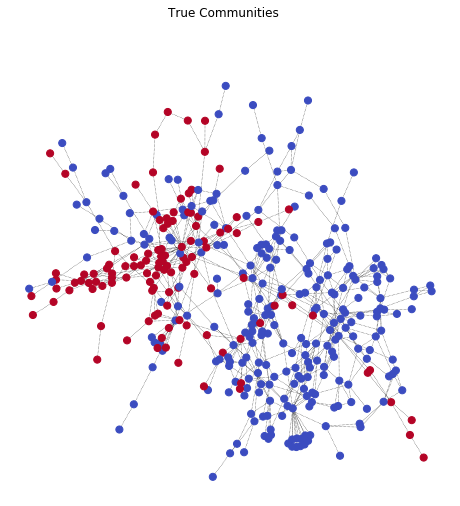

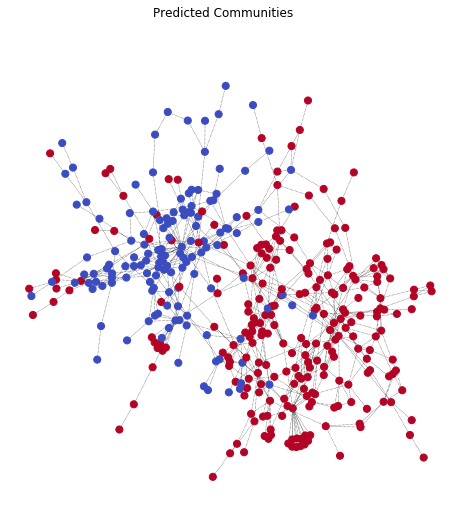

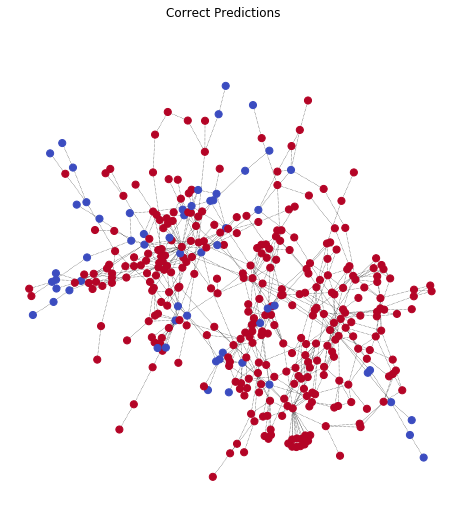

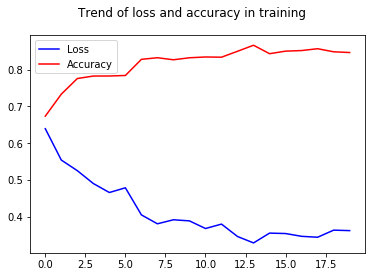

In [0]:
visualize(graph['labels'].cpu(), graph_nx)
plt.suptitle('True Communities')
plt.show()

visualize(pred.data.cpu(), graph_nx)
plt.suptitle('Predicted Communities')
plt.show()

visualize((1 - graph['labels'] == pred).cpu(), graph_nx)
plt.suptitle('Correct Predictions')
plt.show()

plt.plot(range(args.epochs), losses, color='b', label='Loss')
plt.plot(range(args.epochs), accs, color='r', label='Accuracy')
plt.suptitle('Trend of loss and accuracy in training')
plt.legend()
plt.show()